In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae_marginalized.jla import *
import simulators.jla_supernovae_marginalized.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae_marginalized/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Compute projection vectors
Fpinv = np.linalg.inv(F[2:,2:])
P1 = np.dot(Fpinv, F[0,2:])
P2 = np.dot(Fpinv, F[1,2:])

# Simulation args for ABC
simABC_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args, P1, P2, F, prior_args]

# Compressed dataset
data_observed = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

# Do the projection of the data
data_observed = np.dot(F, data_observed - theta_fiducial - np.dot(Finv, np.dot(Qinv, prior_mean - theta_fiducial)))
data_observed = np.dot(Finv[0:2, 0:2], np.array([data_observed[0] - np.dot(P1, data_observed[2:]), data_observed[1] - np.dot(P2, data_observed[2:])]))
data_observed = data_observed + theta_fiducial[:2] + np.dot(Finv[:2,:2], np.dot(Qinv[:2,:2], prior_mean[:2] - theta_fiducial[:2]))
data = data_observed

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae_marginalized/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [4]:
# Create prior over parameters
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
Q = np.diag([0.4, 0.75])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([0.3, -0.75])
Finv = Finv[0:2,0:2]
theta_fiducial = np.array([0.20181324,  -0.74762939])
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [5]:
# Create the DELFI MDN object
n_components = 1
names = ['\Omega_m', 'w_0']
labels =  ['\\Omega_m', 'w_0']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 37s 830us/step - loss: 1.8592 - val_loss: 1.4819
Epoch 2/50
45000/45000 [==============================] - 32s 709us/step - loss: 1.4662 - val_loss: 1.4566
Epoch 3/50
45000/45000 [==============================] - 35s 767us/step - loss: 1.4602 - val_loss: 1.4693
Epoch 4/50
45000/45000 [==============================] - 37s 824us/step - loss: 1.4566 - val_loss: 1.4450
Epoch 5/50
45000/45000 [==============================] - 35s 775us/step - loss: 1.4540 - val_loss: 1.4553
Epoch 6/50
45000/45000 [==============================] - 44s 982us/step - loss: 1.4544 - val_loss: 1.4382
Epoch 7/50
45000/45000 [==============================] - 48s 1ms/step - loss: 1.4492 - val_loss: 1.4505
Epoch 8/50
45000/45000 [==============================] - 39s 868us/step - loss: 1.4509 - val_loss: 1.4545
Epoch 9/50
45000/45000 [==============================] - 44

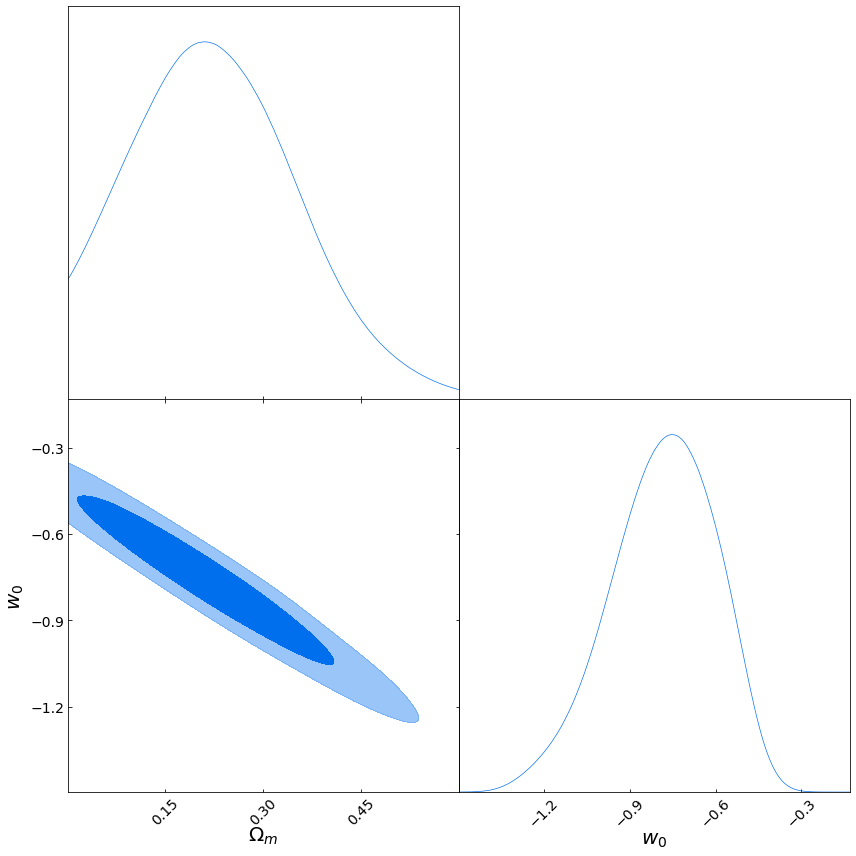

In [6]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 200 sims...
Done.
Train on 180 samples, validate on 20 samples
Epoch 1/100
180/180 [==============================] - 0s 764us/step - loss: 2.9896 - val_loss: 3.4513
Epoch 2/100
180/180 [==============================] - 0s 694us/step - loss: 2.0375 - val_loss: 2.5274
Epoch 3/100
180/180 [==============================] - 0s 678us/step - loss: 1.9112 - val_loss: 2.4294
Epoch 4/100
180/180 [==============================] - 0s 658us/step - loss: 1.8123 - val_loss: 2.2838
Epoch 5/100
180/180 [==============================] - 0s 682us/step - loss: 1.7861 - val_loss: 2.2817
Epoch 6/100
180/180 [==============================] - 0s 742us/step - loss: 1.7564 - val_loss: 2.2813
Epoch 7/100
180/180 [==============================] - 0s 791us/step - loss: 1.7230 - val_loss: 2.2252
Epoch 8/100
180/180 [==============================] - 0s 698us/step - loss: 1.6908 - val_loss: 2.1425
Epoch 9/100
180/180 [==============================] - 0s 729us/step - loss: 1.6738 - val_loss: 2

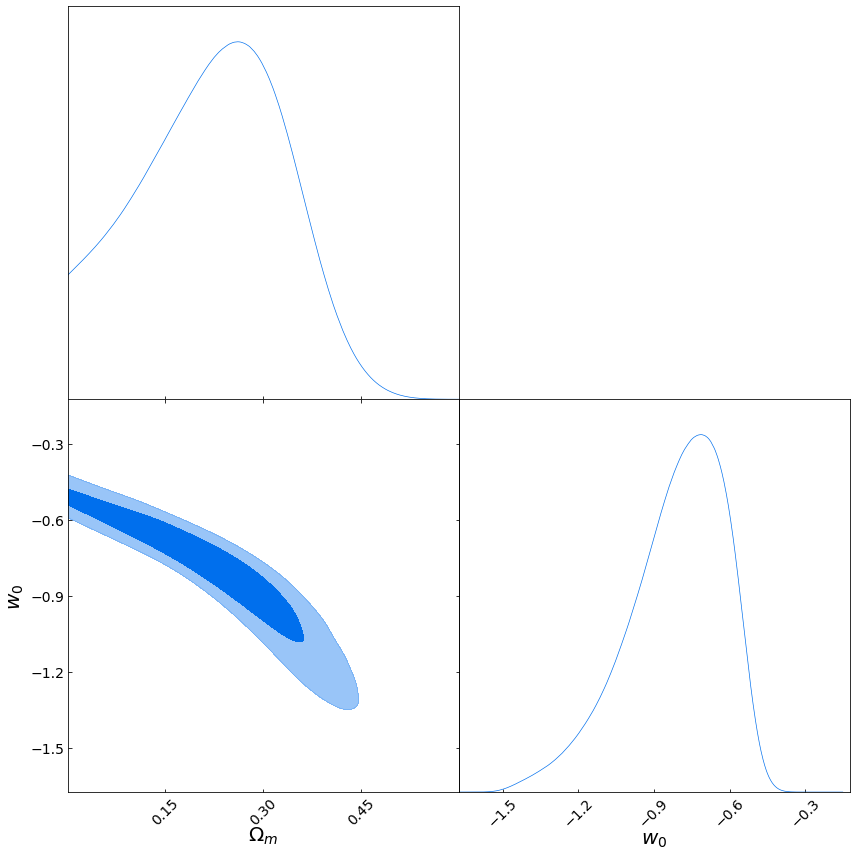

Population 1/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3720 - val_loss: 1.0426
Epoch 2/100
360/360 [==============================] - 0s 898us/step - loss: 1.3699 - val_loss: 1.0912
Epoch 3/100
360/360 [==============================] - 0s 889us/step - loss: 1.3627 - val_loss: 1.0769
Epoch 4/100
360/360 [==============================] - 0s 772us/step - loss: 1.3471 - val_loss: 1.0821
Epoch 5/100
360/360 [==============================] - 0s 744us/step - loss: 1.3504 - val_loss: 1.0896
Epoch 6/100
360/360 [==============================] - 0s 823us/step - loss: 1.3487 - val_loss: 1.1096
Epoch 7/100
360/360 [==============================] - 0s 778us/step - loss: 1.3464 - val_loss: 1.0952
Epoch 8/100
360/360 [==============================] - 0s 704us/step - loss: 1.3533 - val_loss: 1.0758
Epoch 9/100
360/360 [==============================] - 0

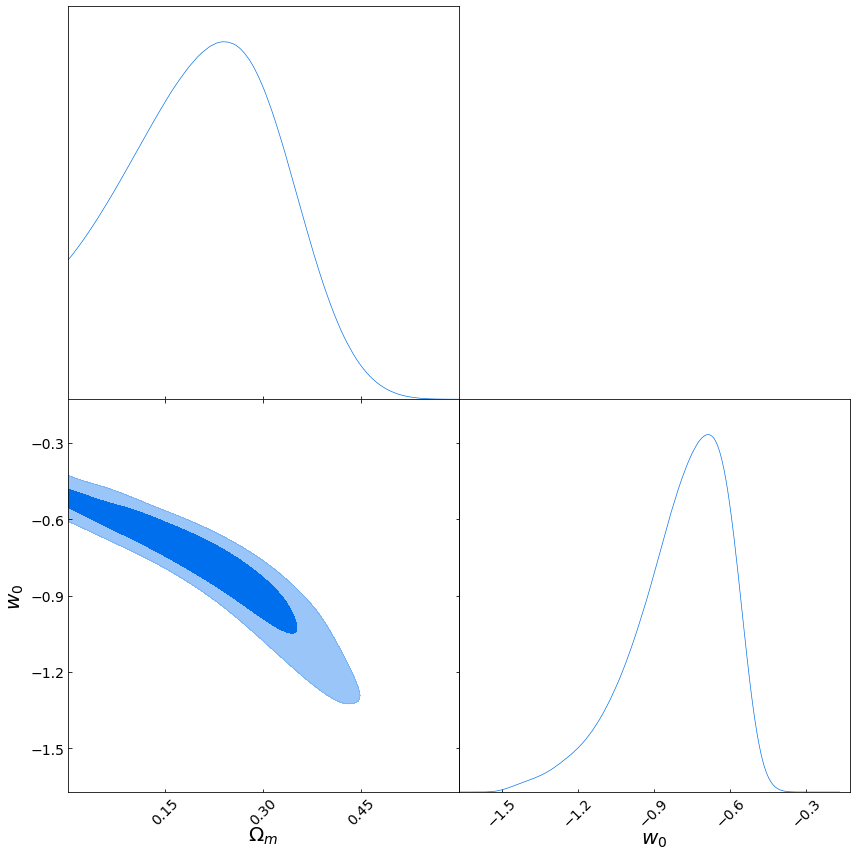

Population 2/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 540 samples, validate on 60 samples
Epoch 1/100
540/540 [==============================] - 0s 898us/step - loss: 1.3157 - val_loss: 1.4783
Epoch 2/100
540/540 [==============================] - 0s 908us/step - loss: 1.3168 - val_loss: 1.4951
Epoch 3/100
540/540 [==============================] - 0s 800us/step - loss: 1.3201 - val_loss: 1.5042
Epoch 4/100
540/540 [==============================] - 0s 856us/step - loss: 1.3155 - val_loss: 1.4865
Epoch 5/100
540/540 [==============================] - 1s 956us/step - loss: 1.3143 - val_loss: 1.4832
Epoch 6/100
540/540 [==============================] - 0s 871us/step - loss: 1.3099 - val_loss: 1.5051
Epoch 7/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3082 - val_loss: 1.4856
Epoch 8/100
540/540 [==============================] - 1s 931us/step - loss: 1.3084 - val_loss: 1.4895
Epoch 9/100
540/540 [==============================] - 0

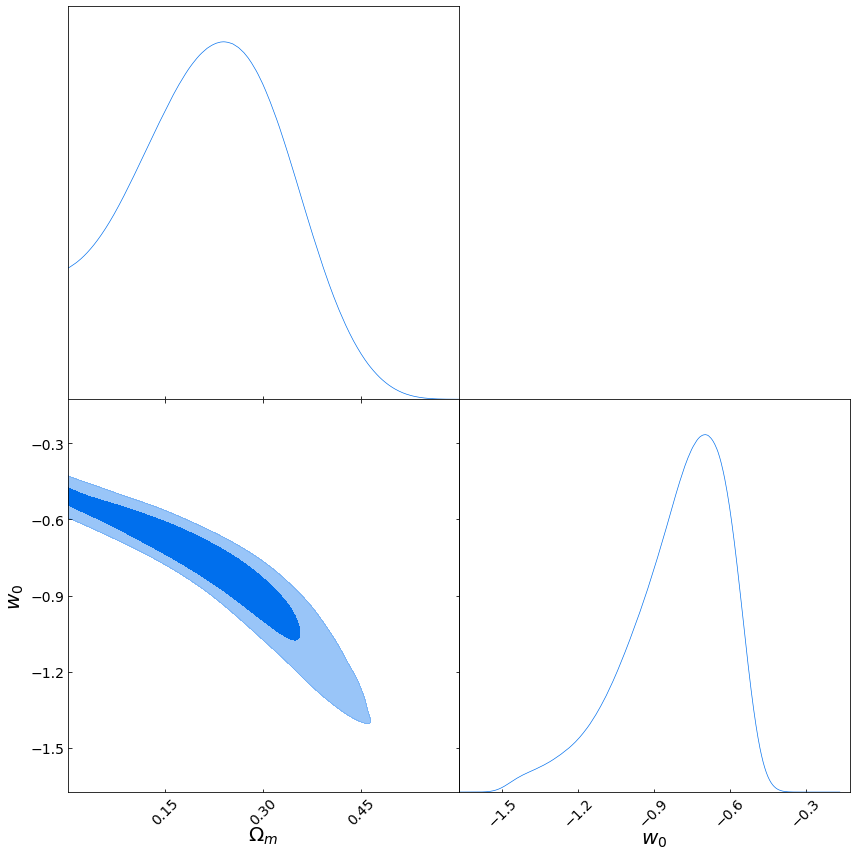

Population 3/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 1s 711us/step - loss: 1.3375 - val_loss: 1.2970
Epoch 2/100
720/720 [==============================] - 0s 657us/step - loss: 1.3285 - val_loss: 1.2720
Epoch 3/100
720/720 [==============================] - 0s 681us/step - loss: 1.3286 - val_loss: 1.2909
Epoch 4/100
720/720 [==============================] - 0s 663us/step - loss: 1.3291 - val_loss: 1.2863
Epoch 5/100
720/720 [==============================] - 0s 680us/step - loss: 1.3299 - val_loss: 1.2749
Epoch 6/100
720/720 [==============================] - 0s 668us/step - loss: 1.3424 - val_loss: 1.3142
Epoch 7/100
720/720 [==============================] - 1s 726us/step - loss: 1.3289 - val_loss: 1.2812
Epoch 8/100
720/720 [==============================] - 1s 701us/step - loss: 1.3387 - val_loss: 1.2794
Epoch 9/100
720/720 [==============================] -

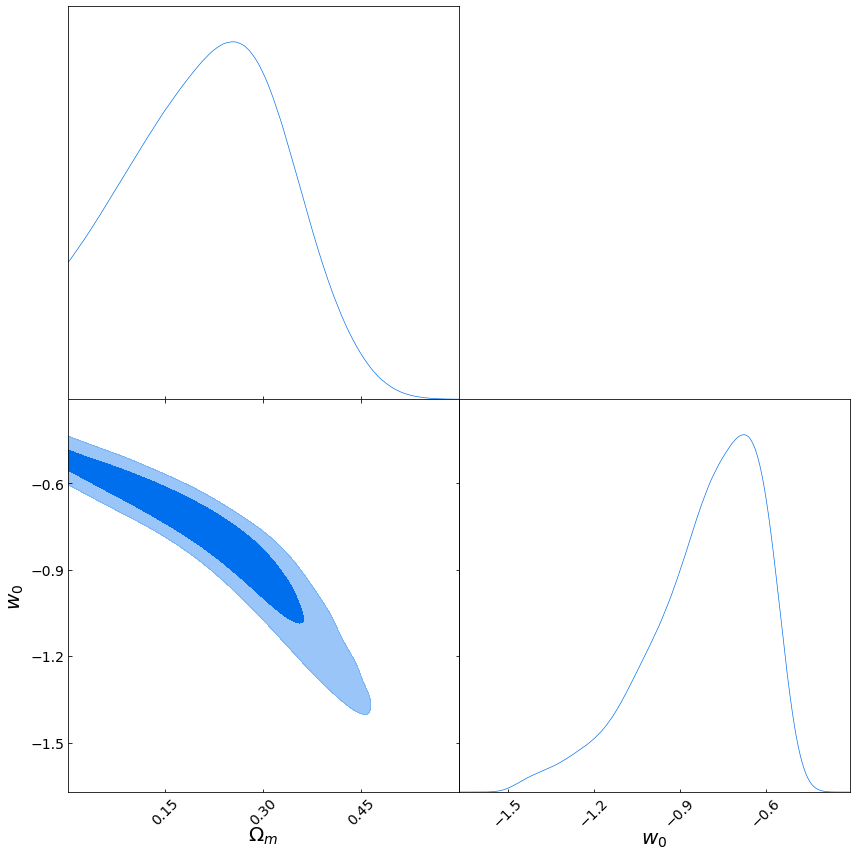

Population 4/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 677us/step - loss: 1.3266 - val_loss: 1.3751
Epoch 2/100
900/900 [==============================] - 1s 719us/step - loss: 1.3288 - val_loss: 1.3685
Epoch 3/100
900/900 [==============================] - 1s 712us/step - loss: 1.3216 - val_loss: 1.3656
Epoch 4/100
900/900 [==============================] - 1s 722us/step - loss: 1.3261 - val_loss: 1.3768
Epoch 5/100
900/900 [==============================] - 1s 680us/step - loss: 1.3282 - val_loss: 1.3730
Epoch 6/100
900/900 [==============================] - 1s 644us/step - loss: 1.3264 - val_loss: 1.3613
Epoch 7/100
900/900 [==============================] - 1s 684us/step - loss: 1.3264 - val_loss: 1.3658
Epoch 8/100
900/900 [==============================] - 1s 676us/step - loss: 1.3347 - val_loss: 1.4104
Epoch 9/100
900/900 [==============================] 

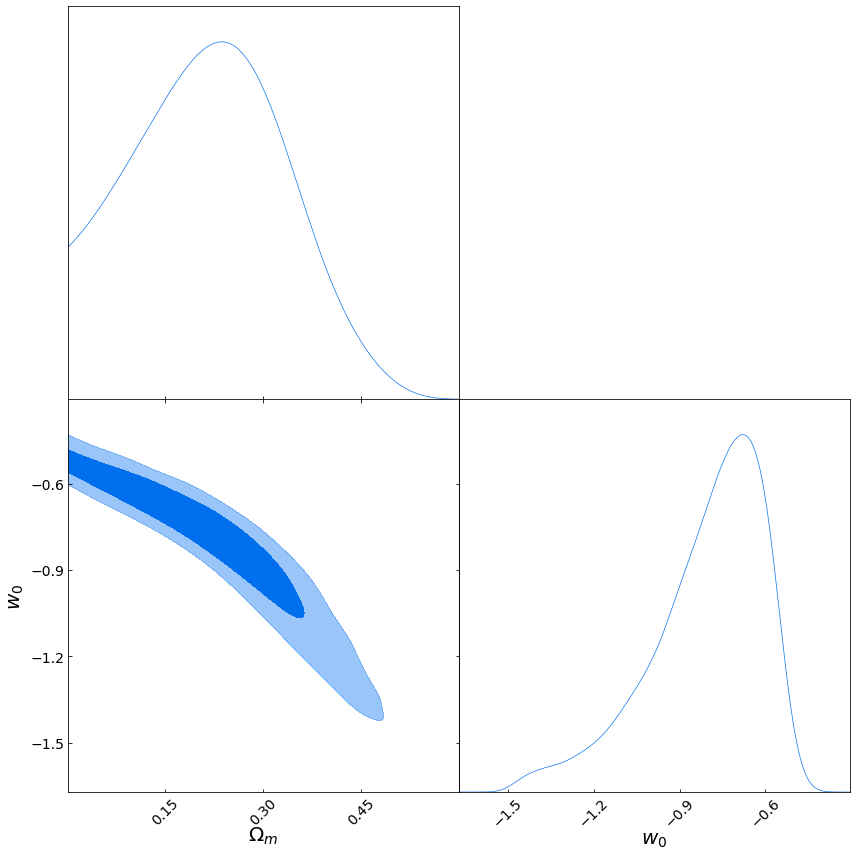

Population 5/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1080 samples, validate on 120 samples
Epoch 1/100
1080/1080 [==============================] - 1s 688us/step - loss: 1.3385 - val_loss: 1.3803
Epoch 2/100
1080/1080 [==============================] - 1s 707us/step - loss: 1.3309 - val_loss: 1.3584
Epoch 3/100
1080/1080 [==============================] - 1s 674us/step - loss: 1.3298 - val_loss: 1.3444
Epoch 4/100
1080/1080 [==============================] - 1s 692us/step - loss: 1.3291 - val_loss: 1.3601
Epoch 5/100
1080/1080 [==============================] - 1s 701us/step - loss: 1.3271 - val_loss: 1.3595
Epoch 6/100
1080/1080 [==============================] - 1s 703us/step - loss: 1.3312 - val_loss: 1.3507
Epoch 7/100
1080/1080 [==============================] - 1s 682us/step - loss: 1.3303 - val_loss: 1.3335
Epoch 8/100
1080/1080 [==============================] - 1s 694us/step - loss: 1.3324 - val_loss: 1.3508
Epoch 9/100
1080/1080 [=============

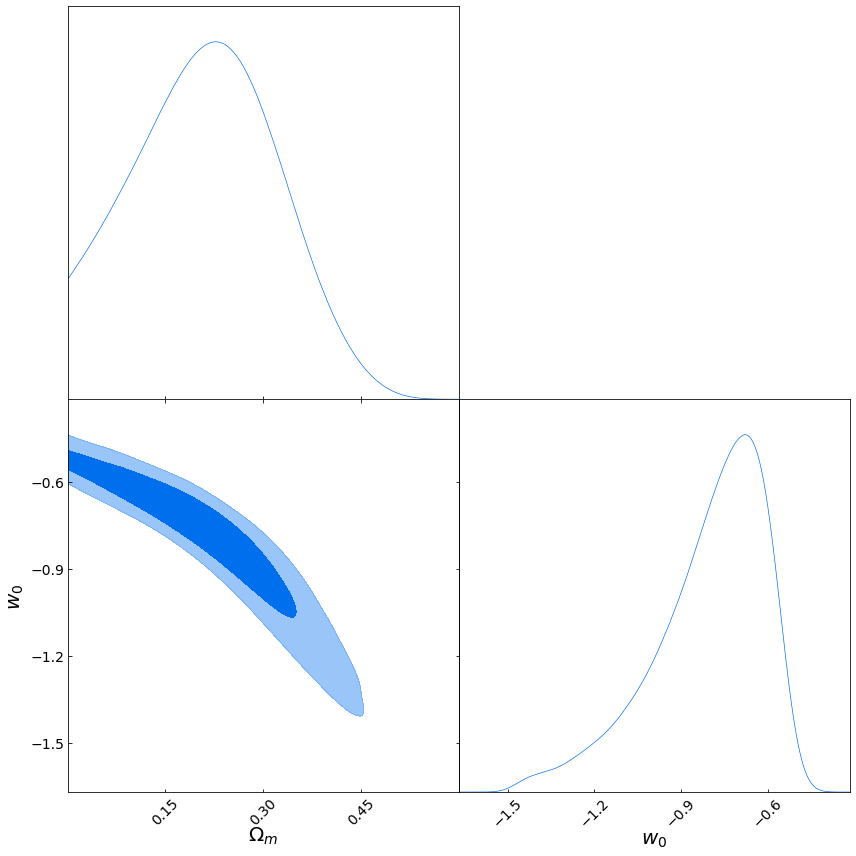

Population 6/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1260 samples, validate on 140 samples
Epoch 1/100
1260/1260 [==============================] - 1s 650us/step - loss: 1.3467 - val_loss: 1.3003
Epoch 2/100
1260/1260 [==============================] - 1s 668us/step - loss: 1.3378 - val_loss: 1.2992
Epoch 3/100
1260/1260 [==============================] - 1s 637us/step - loss: 1.3452 - val_loss: 1.2893
Epoch 4/100
1260/1260 [==============================] - 1s 668us/step - loss: 1.3353 - val_loss: 1.2905
Epoch 5/100
1260/1260 [==============================] - 1s 634us/step - loss: 1.3354 - val_loss: 1.2895
Epoch 6/100
1260/1260 [==============================] - 1s 630us/step - loss: 1.3363 - val_loss: 1.3011
Epoch 7/100
1260/1260 [==============================] - 1s 634us/step - loss: 1.3335 - val_loss: 1.3020
Epoch 8/100
1260/1260 [==============================] - 1s 638us/step - loss: 1.3325 - val_loss: 1.2982
Epoch 9/100
1260/1260 [=============

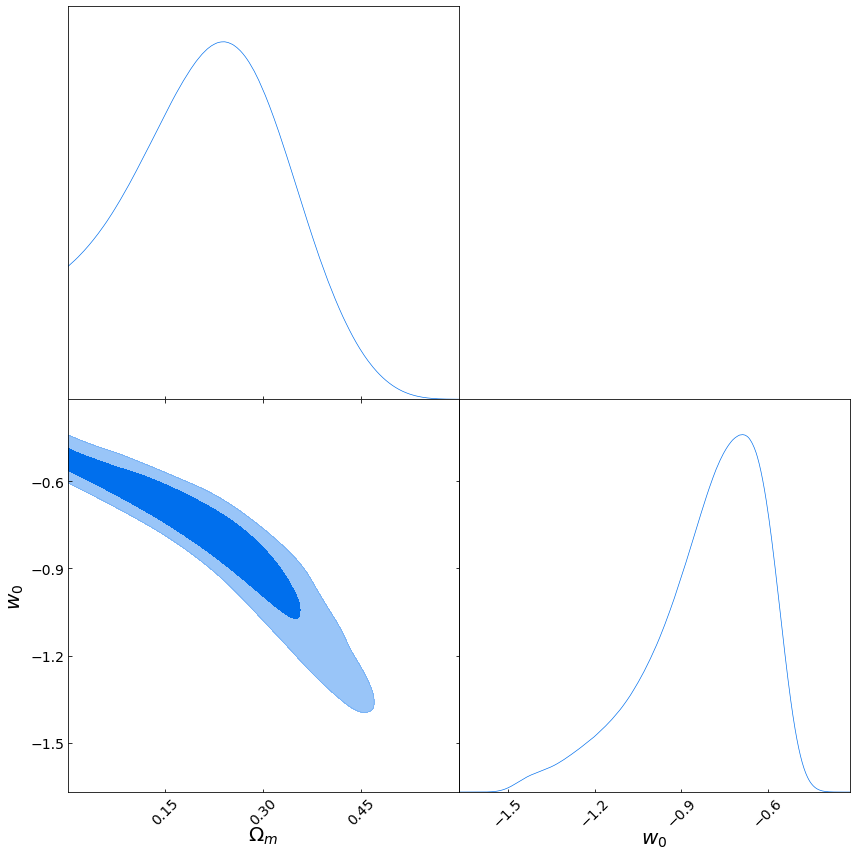

Population 7/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1440 samples, validate on 160 samples
Epoch 1/100
1440/1440 [==============================] - 2s 2ms/step - loss: 1.3300 - val_loss: 1.1688
Epoch 2/100
1440/1440 [==============================] - 2s 2ms/step - loss: 1.3301 - val_loss: 1.1782
Epoch 3/100
1440/1440 [==============================] - 2s 2ms/step - loss: 1.3292 - val_loss: 1.1724
Epoch 4/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3346 - val_loss: 1.1973
Epoch 5/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3411 - val_loss: 1.1745
Epoch 6/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3414 - val_loss: 1.2132
Epoch 7/100
1440/1440 [==============================] - 1s 745us/step - loss: 1.3377 - val_loss: 1.1776
Epoch 8/100
1440/1440 [==============================] - 1s 745us/step - loss: 1.3353 - val_loss: 1.1983
Epoch 9/100
1440/1440 [=========================

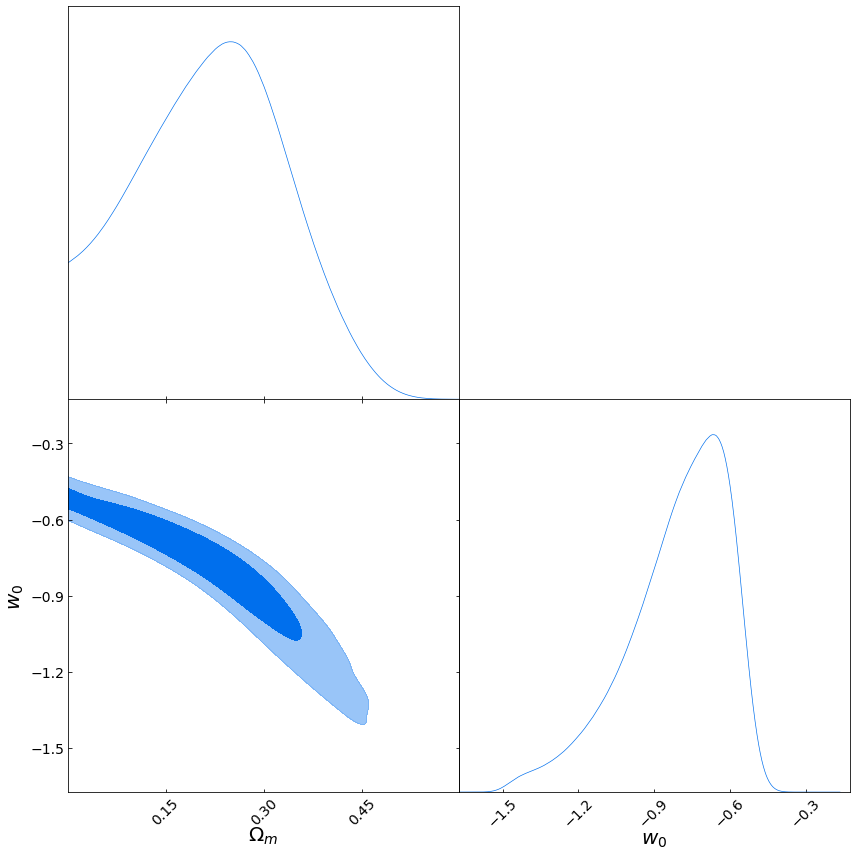

Population 8/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 1s 631us/step - loss: 1.3154 - val_loss: 1.3427
Epoch 2/100
1620/1620 [==============================] - 1s 659us/step - loss: 1.3161 - val_loss: 1.3476
Epoch 3/100
1620/1620 [==============================] - 1s 691us/step - loss: 1.3124 - val_loss: 1.3635
Epoch 4/100
1620/1620 [==============================] - 1s 629us/step - loss: 1.3144 - val_loss: 1.3451
Epoch 5/100
1620/1620 [==============================] - 1s 620us/step - loss: 1.3116 - val_loss: 1.3503
Epoch 6/100
1620/1620 [==============================] - 1s 619us/step - loss: 1.3130 - val_loss: 1.3673
Epoch 7/100
1620/1620 [==============================] - 1s 642us/step - loss: 1.3155 - val_loss: 1.3441
Epoch 8/100
1620/1620 [==============================] - 1s 671us/step - loss: 1.3190 - val_loss: 1.3728
Epoch 9/100
1620/1620 [=============

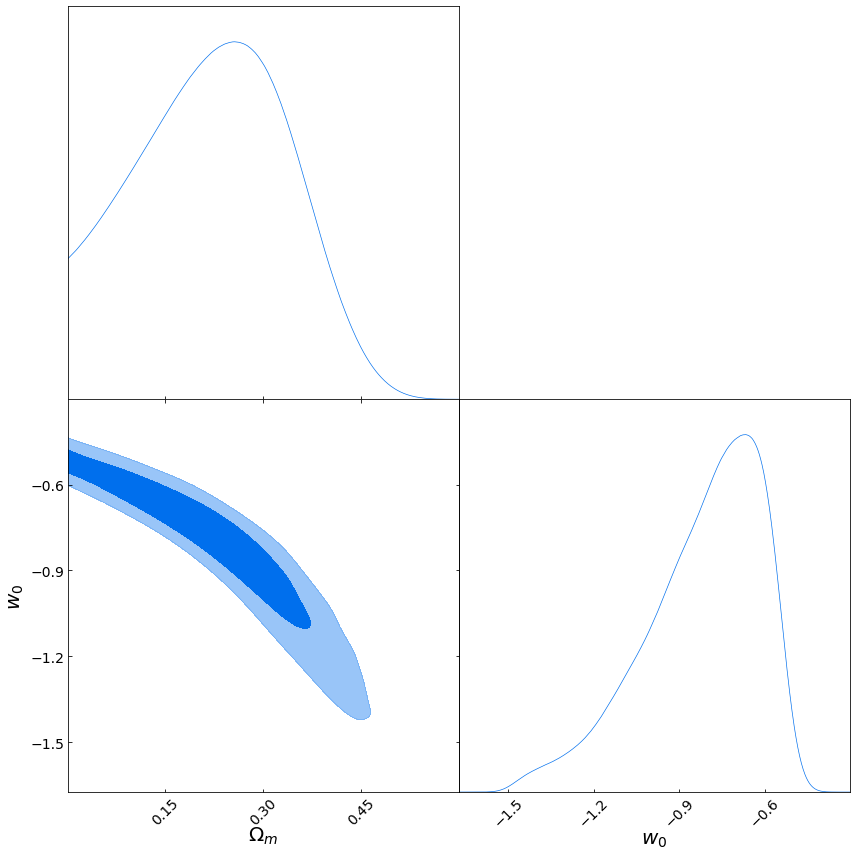

Population 9/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 1s 673us/step - loss: 1.3145 - val_loss: 1.3381
Epoch 2/100
1800/1800 [==============================] - 1s 657us/step - loss: 1.3151 - val_loss: 1.3354
Epoch 3/100
1800/1800 [==============================] - 1s 634us/step - loss: 1.3170 - val_loss: 1.3361
Epoch 4/100
1800/1800 [==============================] - 1s 641us/step - loss: 1.3124 - val_loss: 1.3390
Epoch 5/100
1800/1800 [==============================] - 1s 630us/step - loss: 1.3137 - val_loss: 1.3356
Epoch 6/100
1800/1800 [==============================] - 1s 636us/step - loss: 1.3144 - val_loss: 1.3312
Epoch 7/100
1800/1800 [==============================] - 1s 630us/step - loss: 1.3154 - val_loss: 1.3227
Epoch 8/100
1800/1800 [==============================] - 1s 644us/step - loss: 1.3175 - val_loss: 1.3268
Epoch 9/100
1800/1800 [=============

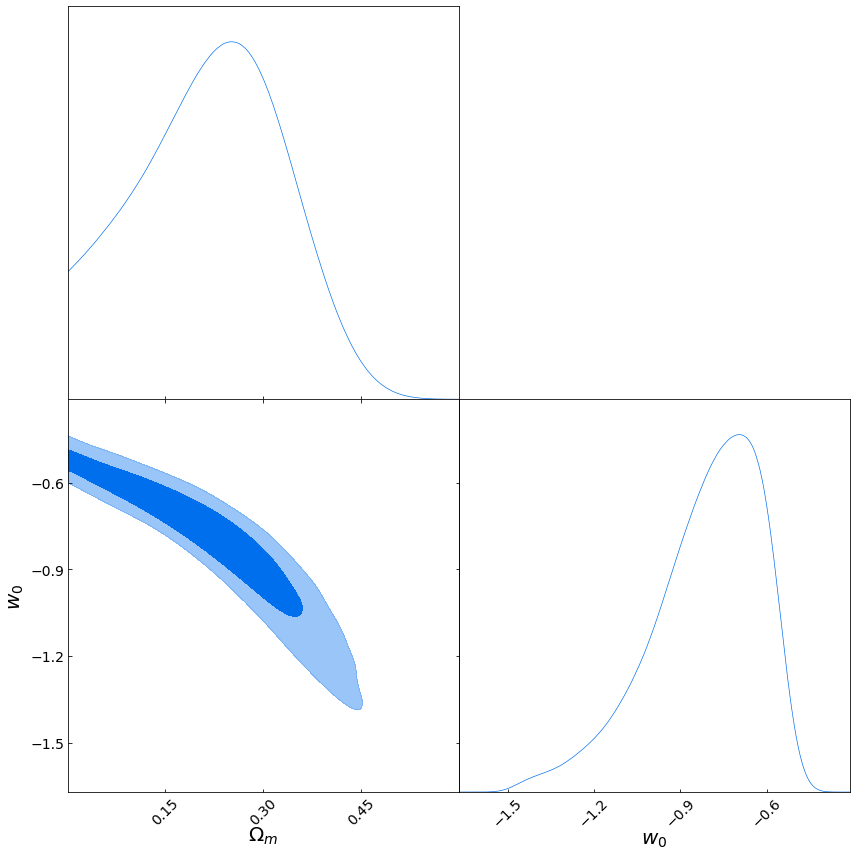

Population 10/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1980 samples, validate on 220 samples
Epoch 1/100
1980/1980 [==============================] - 1s 619us/step - loss: 1.3125 - val_loss: 1.2626
Epoch 2/100
1980/1980 [==============================] - 1s 647us/step - loss: 1.3138 - val_loss: 1.2651
Epoch 3/100
1980/1980 [==============================] - 1s 636us/step - loss: 1.3162 - val_loss: 1.2639
Epoch 4/100
1980/1980 [==============================] - 1s 639us/step - loss: 1.3124 - val_loss: 1.2654
Epoch 5/100
1980/1980 [==============================] - 1s 622us/step - loss: 1.3136 - val_loss: 1.2634
Epoch 6/100
1980/1980 [==============================] - 1s 656us/step - loss: 1.3085 - val_loss: 1.2757
Epoch 7/100
1980/1980 [==============================] - 1s 748us/step - loss: 1.3168 - val_loss: 1.2677
Epoch 8/100
1980/1980 [==============================] - 1s 630us/step - loss: 1.3105 - val_loss: 1.2619
Epoch 9/100
1980/1980 [============

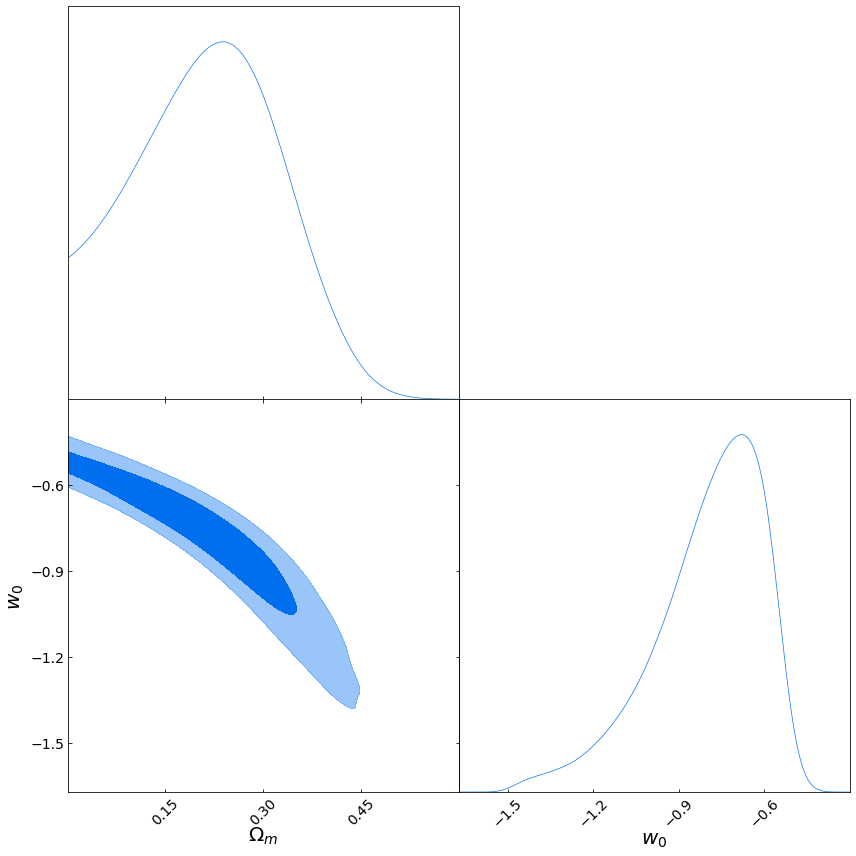

Population 11/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2160 samples, validate on 240 samples
Epoch 1/100
2160/2160 [==============================] - 2s 739us/step - loss: 1.3101 - val_loss: 1.4299
Epoch 2/100
2160/2160 [==============================] - 2s 695us/step - loss: 1.3057 - val_loss: 1.4683
Epoch 3/100
2160/2160 [==============================] - 1s 694us/step - loss: 1.3178 - val_loss: 1.4362
Epoch 4/100
2160/2160 [==============================] - 2s 707us/step - loss: 1.3112 - val_loss: 1.4324
Epoch 5/100
2160/2160 [==============================] - 2s 745us/step - loss: 1.3094 - val_loss: 1.4268
Epoch 6/100
2160/2160 [==============================] - 2s 734us/step - loss: 1.3084 - val_loss: 1.4412
Epoch 7/100
2160/2160 [==============================] - 2s 717us/step - loss: 1.3048 - val_loss: 1.4372
Epoch 8/100
2160/2160 [==============================] - 2s 721us/step - loss: 1.3076 - val_loss: 1.4239
Epoch 9/100
2160/2160 [============

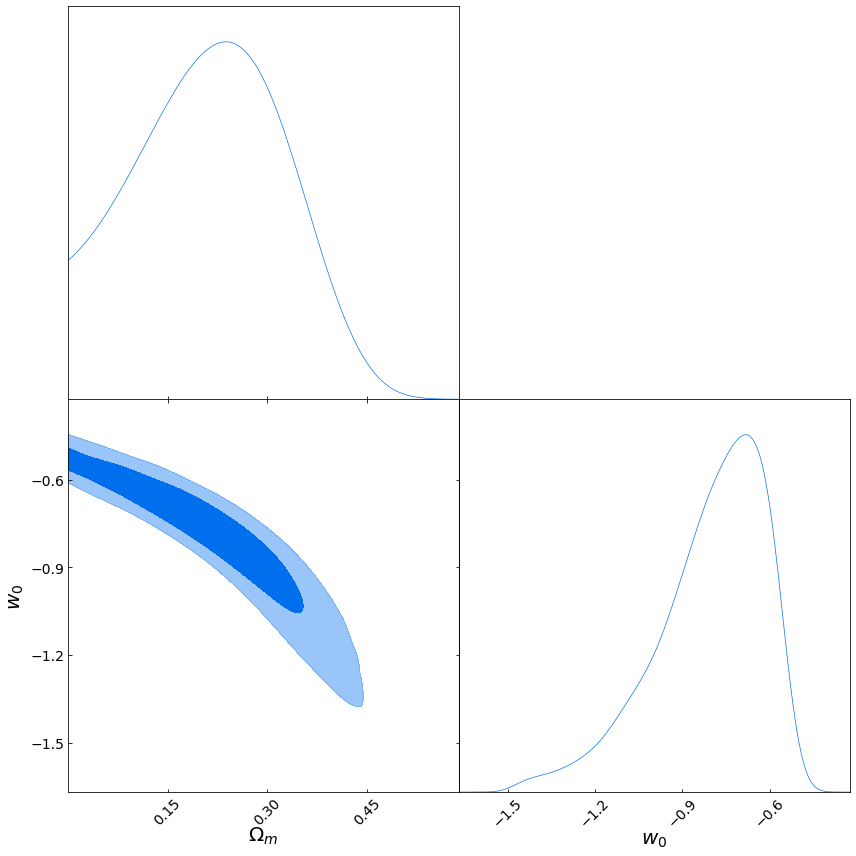

Population 12/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2340 samples, validate on 260 samples
Epoch 1/100
2340/2340 [==============================] - 1s 631us/step - loss: 1.3170 - val_loss: 1.3944
Epoch 2/100
2340/2340 [==============================] - 1s 617us/step - loss: 1.3150 - val_loss: 1.3971
Epoch 3/100
2340/2340 [==============================] - 1s 610us/step - loss: 1.3253 - val_loss: 1.3947
Epoch 4/100
2340/2340 [==============================] - 1s 623us/step - loss: 1.3174 - val_loss: 1.4092
Epoch 5/100
2340/2340 [==============================] - 1s 614us/step - loss: 1.3209 - val_loss: 1.4115
Epoch 6/100
2340/2340 [==============================] - 1s 621us/step - loss: 1.3211 - val_loss: 1.4009
Epoch 7/100
2340/2340 [==============================] - 1s 625us/step - loss: 1.3171 - val_loss: 1.3927
Epoch 8/100
2340/2340 [==============================] - 1s 618us/step - loss: 1.3129 - val_loss: 1.3934
Epoch 9/100
2340/2340 [============

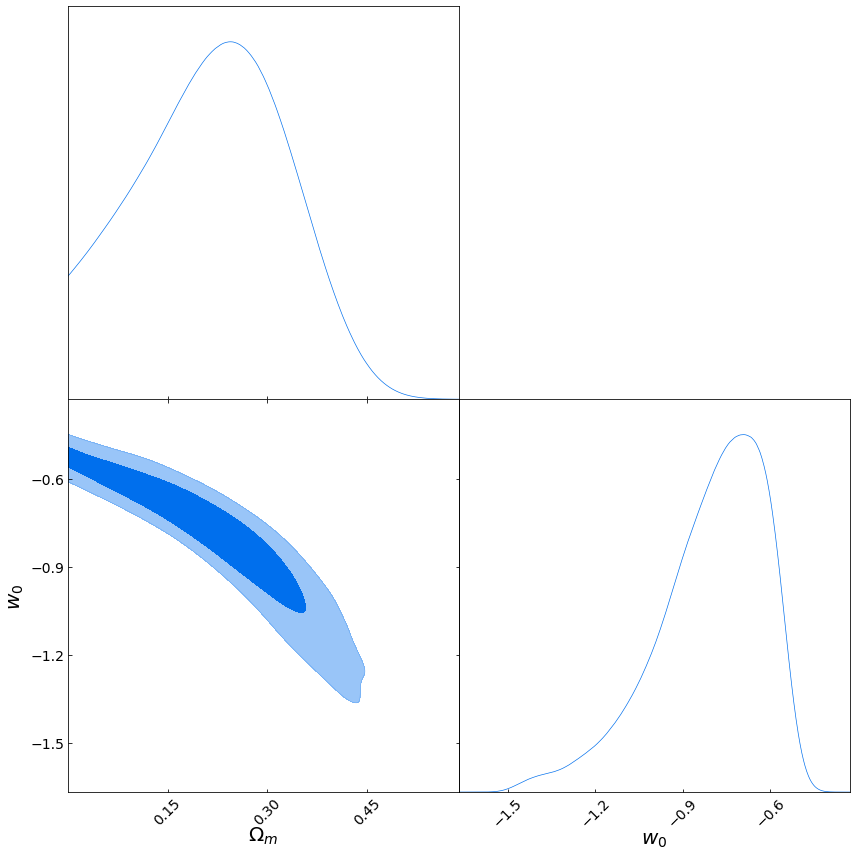

Population 13/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2520 samples, validate on 280 samples
Epoch 1/100
2520/2520 [==============================] - 2s 607us/step - loss: 1.3171 - val_loss: 1.3390
Epoch 2/100
2520/2520 [==============================] - 2s 620us/step - loss: 1.3173 - val_loss: 1.3302
Epoch 3/100
2520/2520 [==============================] - 2s 613us/step - loss: 1.3155 - val_loss: 1.3390
Epoch 4/100
2520/2520 [==============================] - 2s 627us/step - loss: 1.3165 - val_loss: 1.3425
Epoch 5/100
2520/2520 [==============================] - 2s 610us/step - loss: 1.3235 - val_loss: 1.3278
Epoch 6/100
2520/2520 [==============================] - 2s 630us/step - loss: 1.3186 - val_loss: 1.3305
Epoch 7/100
2520/2520 [==============================] - 2s 620us/step - loss: 1.3187 - val_loss: 1.3399
Epoch 8/100
2520/2520 [==============================] - 2s 631us/step - loss: 1.3159 - val_loss: 1.3397
Epoch 9/100
2520/2520 [============

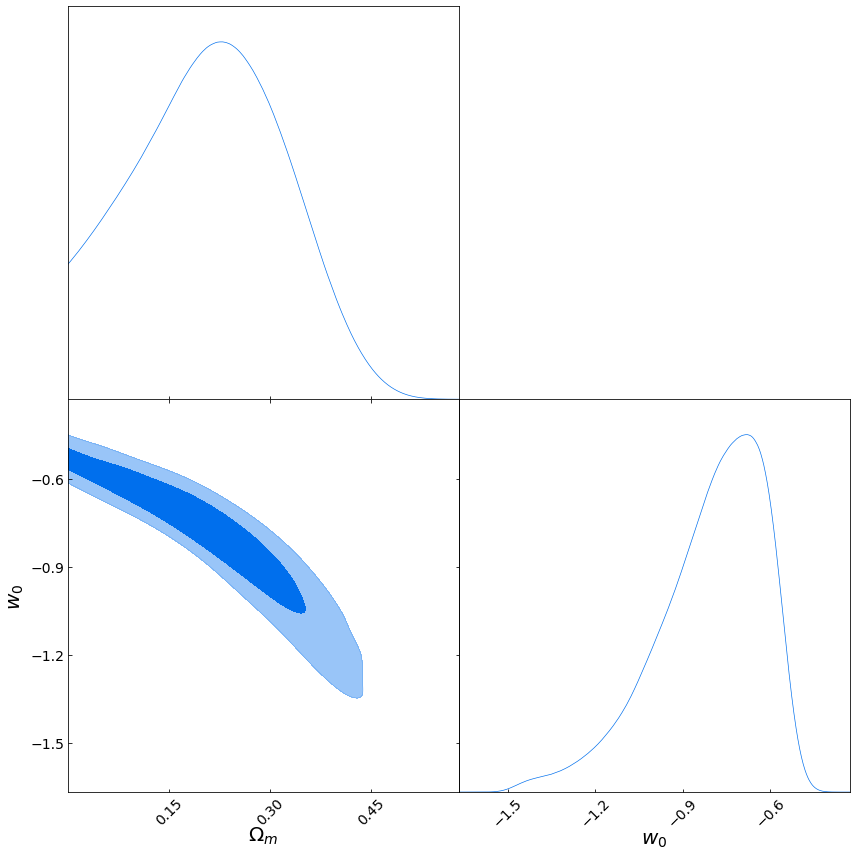

Population 14/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 2s 739us/step - loss: 1.3316 - val_loss: 1.4256
Epoch 2/100
2700/2700 [==============================] - 2s 692us/step - loss: 1.3280 - val_loss: 1.4353
Epoch 3/100
2700/2700 [==============================] - 2s 721us/step - loss: 1.3268 - val_loss: 1.4465
Epoch 4/100
2700/2700 [==============================] - 2s 735us/step - loss: 1.3231 - val_loss: 1.4314
Epoch 5/100
2700/2700 [==============================] - 2s 737us/step - loss: 1.3226 - val_loss: 1.4389
Epoch 6/100
2700/2700 [==============================] - 2s 701us/step - loss: 1.3179 - val_loss: 1.4309
Epoch 7/100
2700/2700 [==============================] - 2s 737us/step - loss: 1.3183 - val_loss: 1.4256
Epoch 8/100
2700/2700 [==============================] - 2s 723us/step - loss: 1.3168 - val_loss: 1.4292
Epoch 9/100
2700/2700 [============

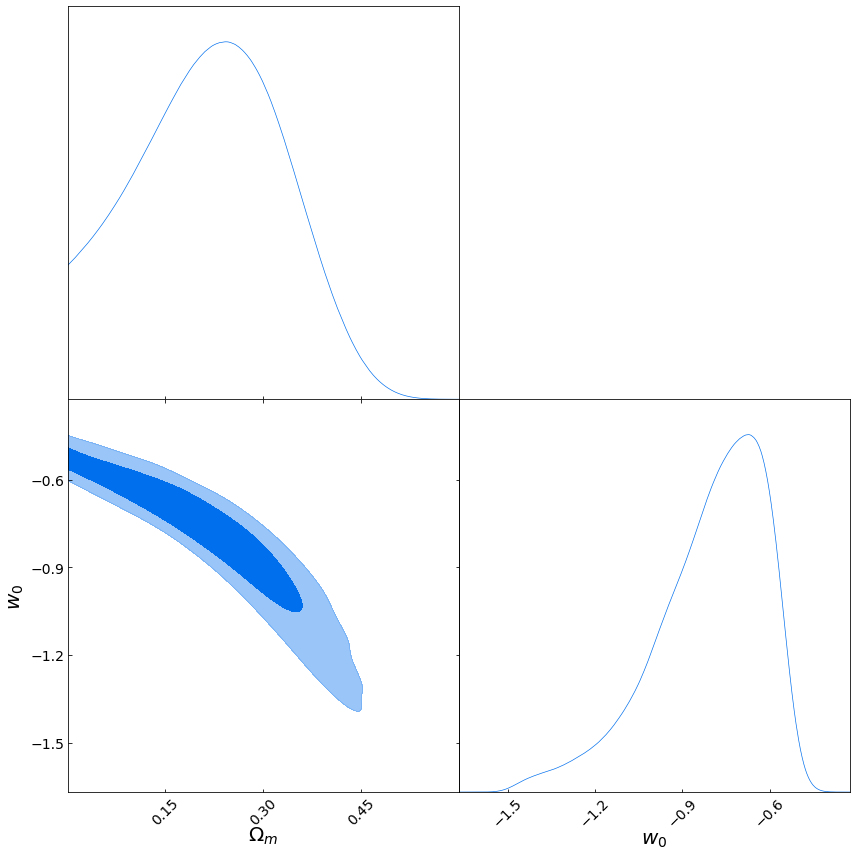

Population 15/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2880 samples, validate on 320 samples
Epoch 1/100
2880/2880 [==============================] - 2s 803us/step - loss: 1.3196 - val_loss: 1.3653
Epoch 2/100
2880/2880 [==============================] - 2s 791us/step - loss: 1.3180 - val_loss: 1.3628
Epoch 3/100
2880/2880 [==============================] - 2s 763us/step - loss: 1.3250 - val_loss: 1.3593
Epoch 4/100
2880/2880 [==============================] - 2s 803us/step - loss: 1.3193 - val_loss: 1.3659
Epoch 5/100
2880/2880 [==============================] - 2s 758us/step - loss: 1.3178 - val_loss: 1.3720
Epoch 6/100
2880/2880 [==============================] - 2s 792us/step - loss: 1.3194 - val_loss: 1.3627
Epoch 7/100
2880/2880 [==============================] - 2s 677us/step - loss: 1.3170 - val_loss: 1.3553
Epoch 8/100
2880/2880 [==============================] - 2s 745us/step - loss: 1.3198 - val_loss: 1.3638
Epoch 9/100
2880/2880 [============

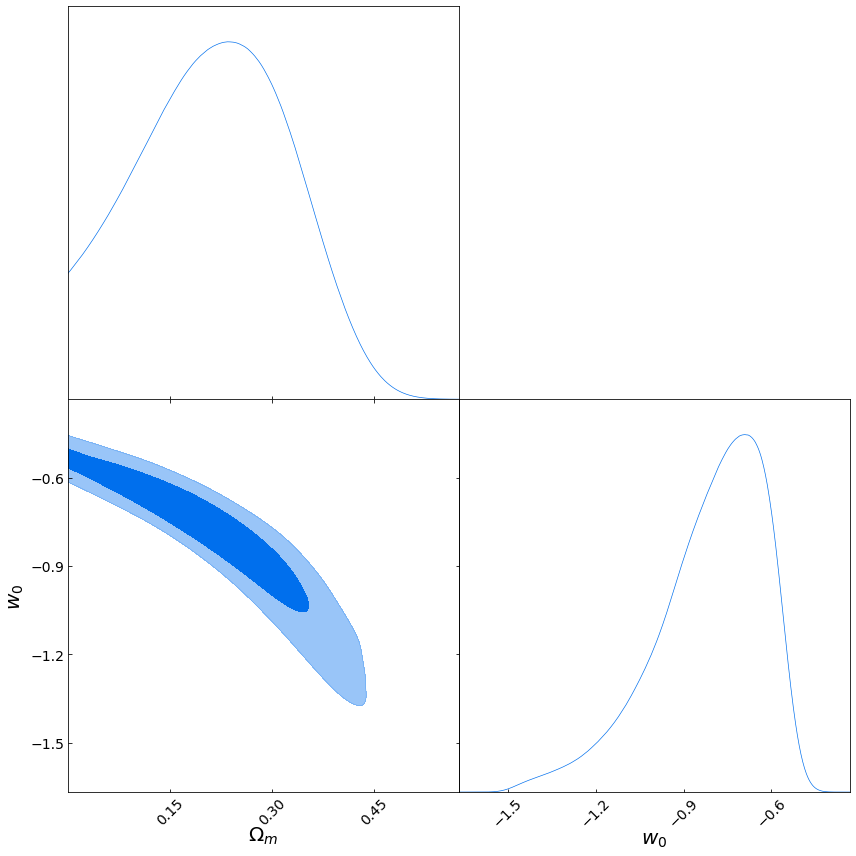

Population 16/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3060 samples, validate on 340 samples
Epoch 1/100
3060/3060 [==============================] - 2s 610us/step - loss: 1.3332 - val_loss: 1.3537
Epoch 2/100
3060/3060 [==============================] - 2s 609us/step - loss: 1.3329 - val_loss: 1.3311
Epoch 3/100
3060/3060 [==============================] - 2s 608us/step - loss: 1.3354 - val_loss: 1.3650
Epoch 4/100
3060/3060 [==============================] - 2s 663us/step - loss: 1.3272 - val_loss: 1.3256
Epoch 5/100
3060/3060 [==============================] - 2s 760us/step - loss: 1.3280 - val_loss: 1.3414
Epoch 6/100
3060/3060 [==============================] - 2s 666us/step - loss: 1.3257 - val_loss: 1.3395
Epoch 7/100
3060/3060 [==============================] - 2s 706us/step - loss: 1.3322 - val_loss: 1.3436
Epoch 8/100
3060/3060 [==============================] - 2s 752us/step - loss: 1.3265 - val_loss: 1.3367
Epoch 9/100
3060/3060 [============

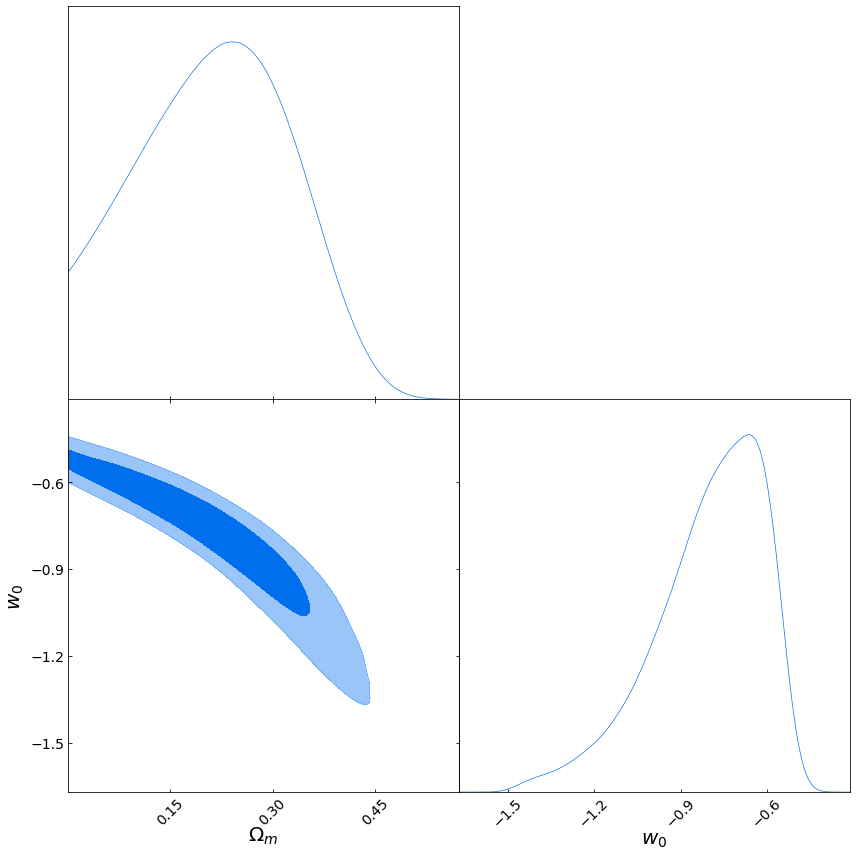

Population 17/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3240 samples, validate on 360 samples
Epoch 1/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3203 - val_loss: 1.3398
Epoch 2/100
3240/3240 [==============================] - 2s 646us/step - loss: 1.3226 - val_loss: 1.3512
Epoch 3/100
3240/3240 [==============================] - 2s 623us/step - loss: 1.3233 - val_loss: 1.3390
Epoch 4/100
3240/3240 [==============================] - 3s 850us/step - loss: 1.3219 - val_loss: 1.3418
Epoch 5/100
3240/3240 [==============================] - 3s 1ms/step - loss: 1.3207 - val_loss: 1.3419
Epoch 6/100
3240/3240 [==============================] - 3s 972us/step - loss: 1.3215 - val_loss: 1.3399
Epoch 7/100
3240/3240 [==============================] - 3s 802us/step - loss: 1.3211 - val_loss: 1.3404
Epoch 8/100
3240/3240 [==============================] - 2s 615us/step - loss: 1.3210 - val_loss: 1.3479
Epoch 9/100
3240/3240 [================

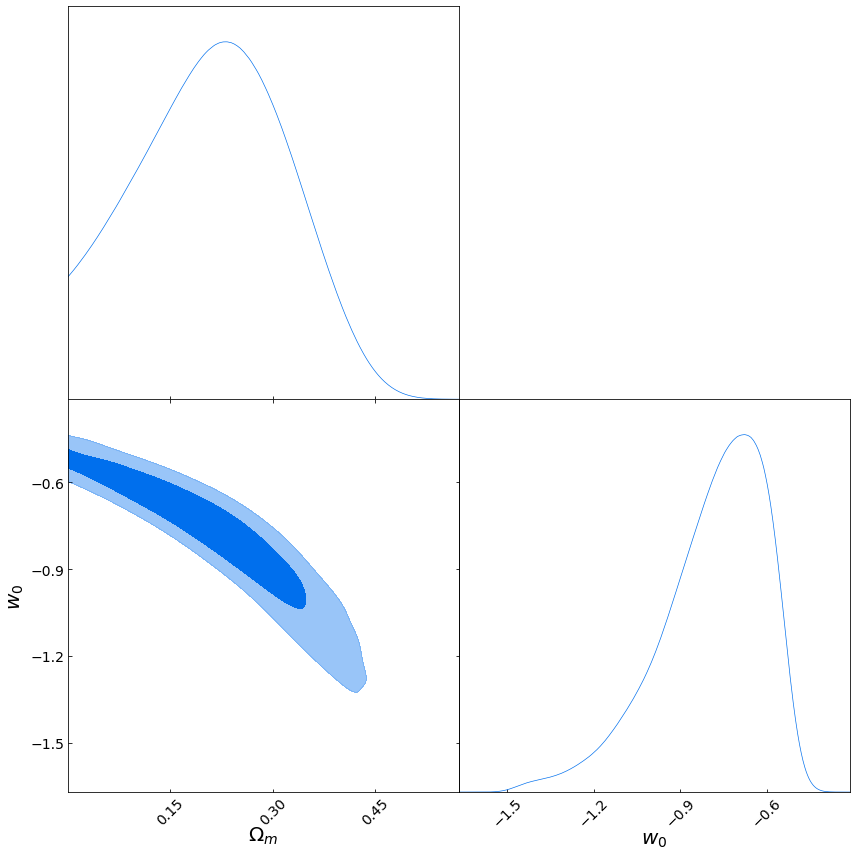

Population 18/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3420 samples, validate on 380 samples
Epoch 1/100
3420/3420 [==============================] - 2s 692us/step - loss: 1.3276 - val_loss: 1.2884
Epoch 2/100
3420/3420 [==============================] - 2s 722us/step - loss: 1.3261 - val_loss: 1.2876
Epoch 3/100
3420/3420 [==============================] - 2s 689us/step - loss: 1.3286 - val_loss: 1.2911
Epoch 4/100
3420/3420 [==============================] - 3s 737us/step - loss: 1.3275 - val_loss: 1.2945
Epoch 5/100
3420/3420 [==============================] - 3s 741us/step - loss: 1.3254 - val_loss: 1.2887
Epoch 6/100
3420/3420 [==============================] - 3s 897us/step - loss: 1.3268 - val_loss: 1.2903
Epoch 7/100
3420/3420 [==============================] - 2s 708us/step - loss: 1.3273 - val_loss: 1.2931
Epoch 8/100
3420/3420 [==============================] - 2s 664us/step - loss: 1.3295 - val_loss: 1.2871
Epoch 9/100
3420/3420 [============

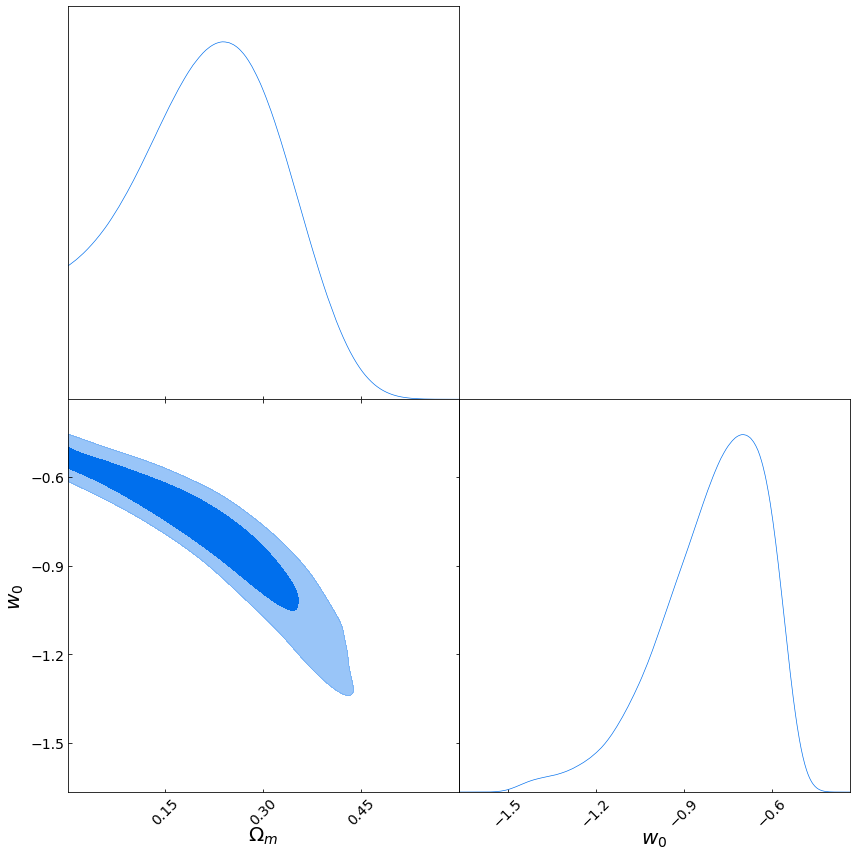

Population 19/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 3s 703us/step - loss: 1.3310 - val_loss: 1.3495
Epoch 2/100
3600/3600 [==============================] - 2s 652us/step - loss: 1.3216 - val_loss: 1.3399
Epoch 3/100
3600/3600 [==============================] - 3s 694us/step - loss: 1.3252 - val_loss: 1.3448
Epoch 4/100
3600/3600 [==============================] - 3s 714us/step - loss: 1.3223 - val_loss: 1.3403
Epoch 5/100
3600/3600 [==============================] - 2s 654us/step - loss: 1.3268 - val_loss: 1.3436
Epoch 6/100
3600/3600 [==============================] - 3s 721us/step - loss: 1.3256 - val_loss: 1.3426
Epoch 7/100
3600/3600 [==============================] - 3s 734us/step - loss: 1.3202 - val_loss: 1.3425
Epoch 8/100
3600/3600 [==============================] - 3s 796us/step - loss: 1.3223 - val_loss: 1.3476
Epoch 9/100
3600/3600 [============

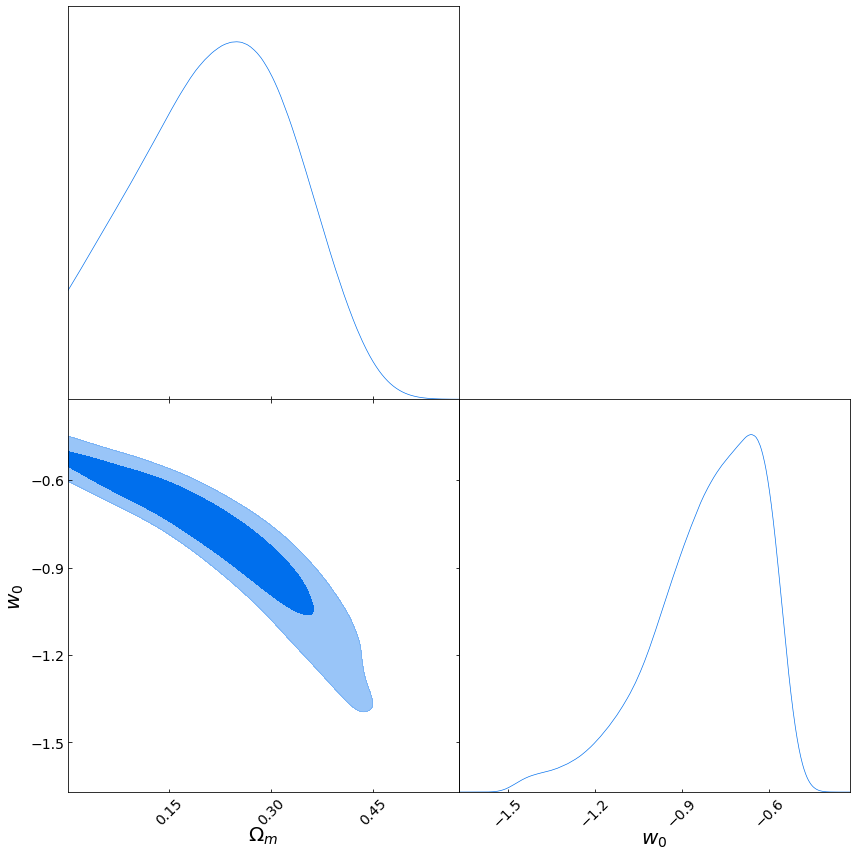

Final round of training with larger SGD batch size...
Train on 3600 samples, validate on 400 samples
Epoch 1/300
3600/3600 [==============================] - 3s 757us/step - loss: 1.3183 - val_loss: 1.3427
Epoch 2/300
3600/3600 [==============================] - 3s 854us/step - loss: 1.3190 - val_loss: 1.3422
Epoch 3/300
3600/3600 [==============================] - 3s 748us/step - loss: 1.3195 - val_loss: 1.3413
Epoch 4/300
3600/3600 [==============================] - 3s 900us/step - loss: 1.3195 - val_loss: 1.3404
Epoch 5/300
3600/3600 [==============================] - 2s 672us/step - loss: 1.3193 - val_loss: 1.3399
Epoch 6/300
3600/3600 [==============================] - 2s 642us/step - loss: 1.3188 - val_loss: 1.3398
Epoch 7/300
3600/3600 [==============================] - 2s 655us/step - loss: 1.3183 - val_loss: 1.3401
Epoch 8/300
3600/3600 [==============================] - 2s 644us/step - loss: 1.3179 - val_loss: 1.3405
Epoch 9/300
3600/3600 [==============================] - 2s

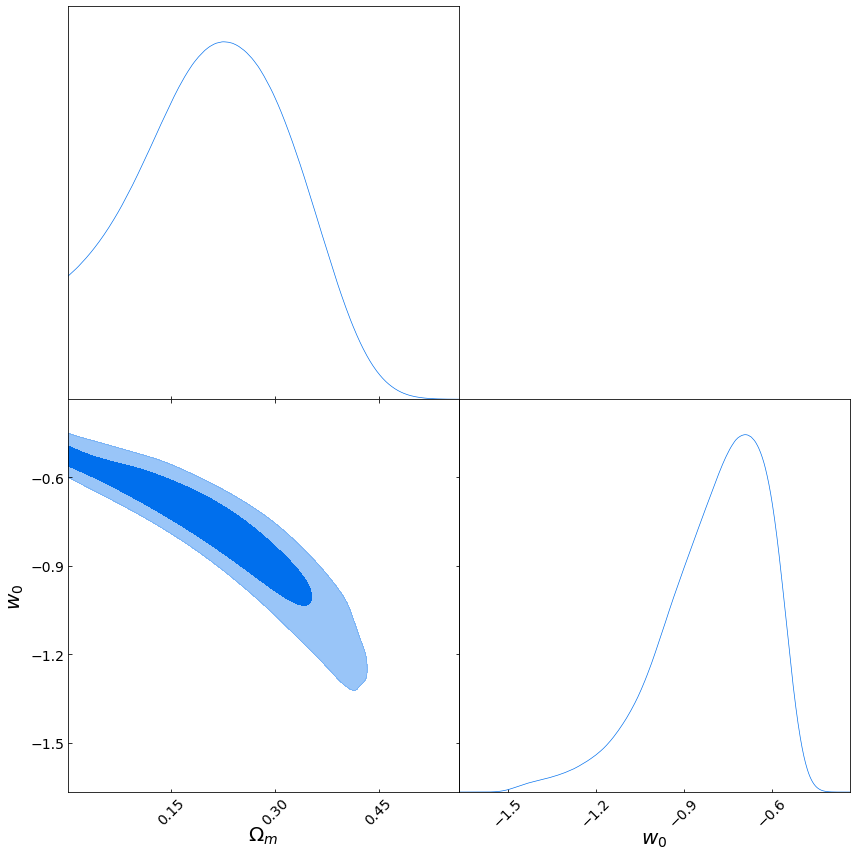

In [7]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 19

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

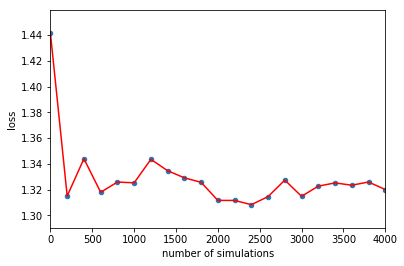

In [8]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()